In [72]:
# Install dependencies (run once)
# !pip install mellea qiskit qiskit-aer qiskit-ibm-runtime numpy matplotlib scipy

# MODULE 2: Iterative Refinement with LLM Critique & Score-Difference Feedback

This module builds on the 7-tier evaluation pipeline from MODULE 1 and adds an
**iterative refinement loop** where the LLM critiques its own circuits, receives
quantitative feedback on score deltas, and generates improved versions.

**Core loop**: Generate → Evaluate → Critique → Regenerate (with feedback)

### Architecture

```
  ┌─────────────┐      ┌───────────────┐      ┌──────────────┐
  │  Generator   │─────▶│  7-Tier Eval  │─────▶│  Composite   │
  │  (LLM)       │      │  Pipeline     │      │  Score       │
  └──────▲───────┘      └───────────────┘      └──────┬───────┘
         │                                            │
         │         ┌───────────────┐                  │
         └─────────│  Critique     │◀─────────────────┘
                   │  Agent (LLM)  │
                   └───────────────┘
```

### Key ideas

- **Composite score** $S \in [0, 1]$: weighted combination of tier pass rate,
  Meyer-Wallach entanglement, distribution entropy, and circuit efficiency.
- **Score-difference feedback**: the refinement prompt includes $\Delta S = S_k - S_{k-1}$
  so the LLM knows whether its last edit helped or hurt.
- **Structured critique**: the LLM produces actionable suggestions (add entanglement,
  reduce depth, fix topology) grounded in the evaluation report.

**Literature**: test-time iterative improvement (Macarone-Palmieri & Lo Franco,
arXiv 2602.03466), self-refine paradigm (Madaan et al., NeurIPS 2023).

**Prerequisites** -- MODULE 1 infrastructure (tiers 1-7), Ollama with `granite3.3:2b`.

## 1. Setup and Imports

In [73]:
import json
import math
import re
import textwrap
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt

import mellea

from qiskit import QuantumCircuit
from qiskit import qasm3
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, entropy
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import SamplerV2 as Sampler

print("All imports loaded.")

All imports loaded.


## 2. Mellea Session Configuration

In [74]:
# ── LLM backend ──────────────────────────────────────────────────────────────
# Change model_id to match whatever you have pulled in Ollama.
# Alternatives: "granite4:tiny-h", "llama3.2:3b", "qwen2.5:3b"
MODEL_ID = "granite3.3:2b"

session = mellea.start_session(
    backend_name="ollama",
    model_id=MODEL_ID,
)
print(f"Mellea session started  --  model: {MODEL_ID}")

=== 03:15:58-INFO ======
Starting Mellea session: backend=ollama, model=granite3.3:2b, context=SimpleContext
Mellea session started  --  model: granite3.3:2b


## 3. Circuit JSON Schema

The LLM outputs circuits as JSON objects conforming to the schema below.
This intermediate representation is framework-agnostic and trivially
translatable to Qiskit, PennyLane, or OpenQASM 3.0.

In [75]:
# ── JSON schema description fed to the LLM ───────────────────────────────────
CIRCUIT_SCHEMA = """
You must output a quantum circuit as valid JSON:
{
  "num_qubits": <int>,
  "gates": [
    {"name": "h", "targets": [0]},
    {"name": "cx", "control": 0, "target": 1},
    {"name": "rz", "targets": [1], "theta": "pi/4"}
  ]
}

Allowed gate names (case-insensitive):
  Single-qubit:  h, x, y, z
  Rotation:      rx, ry, rz  (requires "theta", e.g. "pi/4", 0.785, "pi/2")
  Two-qubit:     cx (CNOT), cz
  Measurement:   measure
"""

# Allowed gate names used for schema validation
ALLOWED_GATES = {"h", "x", "y", "z", "rx", "ry", "rz", "cx", "cnot", "cz", "measure"}

print("Circuit schema defined.")

Circuit schema defined.


## 4. LLM Circuit Generator

The system prompt enforces shallow depth (at most 10 gates) while leaving
qubit count unconstrained. The agent is instructed to avoid textbook circuits
and to output raw JSON with no surrounding prose.

In [76]:
# ── System prompt ─────────────────────────────────────────────────────────────
GENERATOR_SYSTEM_PROMPT = f"""You are a quantum algorithms researcher.

Your goal:
- Propose novel, compact quantum circuits.
- Focus on entanglement, interference, or variational structure.
- Avoid textbook circuits (Bell pair, GHZ, QFT).

Constraints:
- Use between 2 and 8 qubits.
- At most 10 gates total (keep the circuit shallow).
- Output valid JSON ONLY -- no markdown fences, no explanation.

{CIRCUIT_SCHEMA}"""


def generate_circuit(goal: str) -> str:
    """Ask the LLM to propose a circuit for *goal* and return the raw text."""
    prompt = (
        f"{GENERATOR_SYSTEM_PROMPT}\n\n"
        f"Task: Design a quantum circuit for: {goal}\n\n"
        "Respond with valid JSON only, no explanation."
    )
    response = session.instruct(prompt)
    return str(response)


print("Generator ready.")

Generator ready.


## 5. JSON Extraction and Parsing Utilities

Small helpers that bridge the gap between free-form LLM text and the
structured JSON we need. `extract_json` handles markdown code fences,
`parse_theta` handles symbolic expressions like `"pi/4"`.

In [77]:
def extract_json(text: str) -> str:
    """Return the first JSON object found in *text*.

    Handles:
      - ```json ... ``` code blocks
      - Bare { ... } objects
    """
    # Try code-block first
    m = re.search(r"```(?:json)?\s*(\{.*?\})\s*```", text, re.DOTALL)
    if m:
        return m.group(1)
    # Bare JSON
    m = re.search(r"\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}", text, re.DOTALL)
    if m:
        return m.group(0)
    return text


def parse_theta(value) -> float:
    """Convert a theta value (number or string like 'pi/4') to float radians."""
    if isinstance(value, (int, float)):
        return float(value)
    s = str(value).strip().replace("pi", str(math.pi)).replace("\u03c0", str(math.pi))
    try:
        return float(eval(s))
    except Exception:
        return math.pi / 4   # safe fallback


print("Parsing utilities ready.")

Parsing utilities ready.


## 6. Circuit Builder

Translates the JSON spec into a `qiskit.QuantumCircuit`. Qubit indices are
clamped so an out-of-range index from the LLM never crashes the build.

In [78]:
def build_qiskit_circuit(spec: dict) -> QuantumCircuit:
    """Build a QuantumCircuit from a JSON circuit specification.

    Handles flexible key naming the LLM might use ('targets' vs 'target',
    'control' vs 'controls', etc.).
    """
    n = spec["num_qubits"]
    qc = QuantumCircuit(n)

    def clamp(q: int) -> int:
        return max(0, min(int(q), n - 1))

    for gate in spec.get("gates", []):
        name = gate["name"].lower()

        # ── single-qubit gates ──────────────────────────────────────────
        if name in ("h", "x", "y", "z"):
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                getattr(qc, name)(clamp(t))

        # ── rotation gates ──────────────────────────────────────────────
        elif name in ("rx", "ry", "rz"):
            theta = parse_theta(gate.get("theta", "pi/4"))
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                getattr(qc, name)(theta, clamp(t))

        # ── two-qubit gates ─────────────────────────────────────────────
        elif name in ("cx", "cnot"):
            ctrl = gate.get("control", gate.get("controls", [0]))
            tgt = gate.get("target", gate.get("targets", 1))
            if isinstance(ctrl, list):
                ctrl = ctrl[0]
            if isinstance(tgt, list):
                tgt = tgt[0]
            ctrl, tgt = clamp(ctrl), clamp(tgt)
            if ctrl == tgt:
                tgt = (ctrl + 1) % n
            qc.cx(ctrl, tgt)

        elif name == "cz":
            ctrl = gate.get("control", gate.get("controls", [0]))
            tgt = gate.get("target", gate.get("targets", 1))
            if isinstance(ctrl, list):
                ctrl = ctrl[0]
            if isinstance(tgt, list):
                tgt = tgt[0]
            ctrl, tgt = clamp(ctrl), clamp(tgt)
            if ctrl == tgt:
                tgt = (ctrl + 1) % n
            qc.cz(ctrl, tgt)

        # ── measure (ignored during statevector eval) ───────────────────
        elif name == "measure":
            pass   # measurements added explicitly when needed

    return qc


print("Circuit builder ready.")

Circuit builder ready.


---

## 7. Evaluation Tiers

Each tier is a standalone function that returns a dict with at least two keys:
`"pass"` (bool) and `"details"` (anything JSON-serialisable). Tiers are ordered
by cost: cheap sanity checks first, expensive hardware execution last.

### Tier 1 -- Schema and JSON Validation

In [79]:
def tier1_schema_validation(raw_text: str) -> Dict[str, Any]:
    """Tier 1: Parse JSON from LLM output and validate against the circuit schema.

    Checks:
      - JSON is syntactically valid.
      - Required keys 'num_qubits' and 'gates' are present.
      - Every gate name is in the allowed set.
      - num_qubits is a positive integer.

    Returns dict with keys 'pass', 'spec' (parsed dict or None), 'details'.
    """
    result: Dict[str, Any] = {"pass": False, "spec": None, "details": {}}

    # -- extract JSON --------------------------------------------------------
    try:
        json_str = extract_json(raw_text)
        spec = json.loads(json_str)
    except (json.JSONDecodeError, Exception) as exc:
        result["details"]["error"] = f"JSON parse error: {exc}"
        return result

    # -- required keys -------------------------------------------------------
    missing = [k for k in ("num_qubits", "gates") if k not in spec]
    if missing:
        result["details"]["error"] = f"Missing required keys: {missing}"
        result["spec"] = spec
        return result

    # -- num_qubits sanity ---------------------------------------------------
    if not isinstance(spec["num_qubits"], int) or spec["num_qubits"] < 1:
        result["details"]["error"] = f"num_qubits must be a positive int, got {spec['num_qubits']}"
        result["spec"] = spec
        return result

    # -- gate names ----------------------------------------------------------
    invalid_gates: List[str] = []
    for g in spec.get("gates", []):
        name = str(g.get("name", "")).lower()
        if name not in ALLOWED_GATES:
            invalid_gates.append(name)
    if invalid_gates:
        result["details"]["warning"] = f"Unknown gate names (will be skipped): {invalid_gates}"

    result["pass"] = True
    result["spec"] = spec
    result["details"]["num_qubits"] = spec["num_qubits"]
    result["details"]["num_gates"] = len(spec.get("gates", []))
    return result


print("Tier 1 (schema validation) ready.")

Tier 1 (schema validation) ready.


### Tier 2 -- Compilation Check

Build the Qiskit `QuantumCircuit` from the parsed JSON. If `build_qiskit_circuit`
raises, the circuit is syntactically broken.

In [80]:
def tier2_compilation(spec: dict) -> Dict[str, Any]:
    """Tier 2: Attempt to build a QuantumCircuit from the spec.

    Returns dict with 'pass', 'circuit' (QuantumCircuit or None), 'details'.
    """
    result: Dict[str, Any] = {"pass": False, "circuit": None, "details": {}}
    try:
        qc = build_qiskit_circuit(spec)
        result["pass"] = True
        result["circuit"] = qc
        result["details"]["depth"] = qc.depth()
        result["details"]["width"] = qc.num_qubits
        result["details"]["gate_counts"] = dict(qc.count_ops())
    except Exception as exc:
        result["details"]["error"] = str(exc)
    return result


print("Tier 2 (compilation) ready.")

Tier 2 (compilation) ready.


### Tier 3 -- Simulator Execution

Run the circuit on `AerSimulator` with 1024 shots. A trivially broken circuit
would either crash here or return a single all-zeros outcome.

In [81]:
def tier3_simulation(qc: QuantumCircuit, shots: int = 1024) -> Dict[str, Any]:
    """Tier 3: Execute the circuit on AerSimulator.

    Returns dict with 'pass', 'counts', 'details'.
    A pass requires at least one non-zero count.
    """
    result: Dict[str, Any] = {"pass": False, "counts": {}, "details": {}}
    try:
        sim = AerSimulator()
        qc_m = qc.copy()
        qc_m.measure_all()
        job = sim.run(qc_m, shots=shots)
        counts = job.result().get_counts()
        result["counts"] = counts
        result["details"]["num_outcomes"] = len(counts)
        result["details"]["shots"] = shots
        result["pass"] = len(counts) > 0
    except Exception as exc:
        result["details"]["error"] = str(exc)
    return result


print("Tier 3 (simulation) ready.")

Tier 3 (simulation) ready.


### Tier 4 -- OpenQASM 3.0 Export

Following Agent-Q (arXiv 2504.11109), syntactic correctness of the
OpenQASM 3.0 representation is a fundamental quality gate.

In [82]:
def tier4_qasm3_export(qc: QuantumCircuit) -> Dict[str, Any]:
    """Tier 4: Export the circuit to OpenQASM 3.0 and verify the string is non-empty.

    Mirrors the syntactic-correctness check used by Agent-Q (arXiv 2504.11109).
    """
    result: Dict[str, Any] = {"pass": False, "qasm3": "", "details": {}}
    try:
        qasm_str = qasm3.dumps(qc)
        result["qasm3"] = qasm_str
        result["details"]["length_chars"] = len(qasm_str)
        result["pass"] = len(qasm_str) > 0
    except Exception as exc:
        result["details"]["error"] = str(exc)
    return result


print("Tier 4 (QASM 3.0 export) ready.")

Tier 4 (QASM 3.0 export) ready.


### Tier 5 -- Transpilation for Target Hardware

Transpile the logical circuit down to the native gate set and coupling map
of **FakeSherbrooke** (127-qubit Eagle r3). Reports ISA depth and gate
counts, which are direct proxies for expected noise.

In [83]:
def tier5_transpilation(
    qc: QuantumCircuit,
    backend=None,
    optimization_level: int = 3,
) -> Dict[str, Any]:
    """Tier 5: Transpile for a target backend.

    Returns ISA circuit, depth, gate counts, and two-qubit gate count
    (a key noise indicator).
    """
    result: Dict[str, Any] = {
        "pass": False,
        "isa_circuit": None,
        "details": {},
    }
    try:
        if backend is None:
            backend = FakeSherbrooke()

        pm = generate_preset_pass_manager(
            optimization_level=optimization_level,
            backend=backend,
        )
        isa = pm.run(qc)

        ops = dict(isa.count_ops())
        depth = isa.depth()
        two_q_count = sum(v for k, v in ops.items() if k in ("cx", "ecr", "cz", "rzz"))

        result["pass"] = True
        result["isa_circuit"] = isa
        result["details"]["isa_depth"] = depth
        result["details"]["isa_gate_counts"] = ops
        result["details"]["two_qubit_gate_count"] = two_q_count
        result["details"]["optimization_level"] = optimization_level
    except Exception as exc:
        result["details"]["error"] = str(exc)
    return result


print("Tier 5 (transpilation) ready.")

Tier 5 (transpilation) ready.


### Tier 6 -- Hardware Execution (Fake Backend)

Execute the transpiled ISA circuit on `FakeSherbrooke` through `SamplerV2`.
This validates that the circuit survives the full Qiskit Runtime submission
path, including classical register handling and bit-array decoding.

In [84]:
from qiskit_aer.noise import NoiseModel

def _remove_idle_qubits(circuit: QuantumCircuit) -> Tuple[QuantumCircuit, List[int]]:
    """Return a copy of *circuit* with idle (unused) qubits removed.

    After transpilation to a 127-qubit backend like FakeSherbrooke, most
    qubits are idle.  Removing them makes AerSimulator execution feasible.

    Returns (compact_circuit, active_qubit_indices).
    """
    active_qubits = set()
    for inst in circuit.data:
        for qubit in inst.qubits:
            active_qubits.add(circuit.find_bit(qubit).index)

    active_list = sorted(active_qubits)

    if len(active_list) == circuit.num_qubits:
        return circuit, active_list

    qubit_map = {old: new for new, old in enumerate(active_list)}

    new_qc = QuantumCircuit(len(active_list))
    for inst in circuit.data:
        old_indices = [circuit.find_bit(q).index for q in inst.qubits]
        new_indices = [qubit_map[i] for i in old_indices]
        new_qc.append(inst.operation, new_indices)

    return new_qc, active_list


def tier6_hardware_execution(
    isa_circuit: QuantumCircuit,
    backend=None,
    shots: int = 4096,
) -> Dict[str, Any]:
    """Tier 6: Execute a transpiled ISA circuit with FakeSherbrooke noise.

    Removes idle qubits first (a 127-qubit ISA circuit with 3 active qubits
    would otherwise require 2^127 amplitudes), then runs AerSimulator with
    the FakeSherbrooke noise model so the results reflect realistic hardware
    error rates (T1/T2, gate errors, readout errors).
    """
    result: Dict[str, Any] = {"pass": False, "counts": {}, "details": {}}
    try:
        # Strip idle qubits
        compact, active_indices = _remove_idle_qubits(isa_circuit)

        qc = compact.copy()
        if qc.num_clbits == 0:
            qc.measure_all()

        # Build a noisy simulator from FakeSherbrooke
        fake_backend = FakeSherbrooke() if backend is None else backend
        noise_model = NoiseModel.from_backend(fake_backend)

        sim = AerSimulator(noise_model=noise_model)
        job = sim.run(qc, shots=shots)
        counts = job.result().get_counts()

        result["pass"] = len(counts) > 0
        result["counts"] = counts
        result["details"]["shots"] = shots
        result["details"]["num_outcomes"] = len(counts)
        result["details"]["active_qubits"] = compact.num_qubits
        result["details"]["original_isa_qubits"] = isa_circuit.num_qubits
        result["details"]["noise_model"] = True
    except Exception as exc:
        result["details"]["error"] = str(exc)
    return result


print("Tier 6 (hardware execution with noise model) ready.")

Tier 6 (hardware execution with noise model) ready.


### Tier 7 -- Physics-Based Quality Metrics

These metrics go beyond "does it run" and quantify the **physical quality** of
the generated state. They are drawn from two recent papers:

1. **Meyer-Wallach (MW) global entanglement** (Macarone-Palmieri & Lo Franco,
   arXiv 2602.03466): $Q(\psi)=\frac{4}{N}\sum_{i=1}^{N}(1-\text{Tr}[\rho_i^2])$,
   where $\rho_i$ is the reduced density matrix of qubit $i$. MW = 0 for product
   states, MW = 1 for maximally entangled states.

2. **Distribution entropy** (Shannon entropy of the measurement distribution) and
   **KL divergence** against a uniform reference (Agent-Q, arXiv 2504.11109).

3. **Von Neumann entanglement entropy** of single-qubit subsystems.

In [85]:
# ── individual metric helpers ─────────────────────────────────────────────────

def meyer_wallach(qc: QuantumCircuit) -> float:
    """Compute the Meyer-Wallach global entanglement measure.

    Q(psi) = (4/N) * sum_i (1 - Tr[rho_i^2])

    where rho_i is the reduced density matrix of qubit i.
    Range: 0 (product state) to 1 (maximally entangled).

    Reference: Meyer & Wallach, J. Math. Phys. 43, 4273 (2002);
               Macarone-Palmieri & Lo Franco, arXiv 2602.03466.
    """
    sv = Statevector.from_instruction(qc)
    rho = DensityMatrix(sv)
    n = qc.num_qubits
    if n < 2:
        return 0.0

    total = 0.0
    for i in range(n):
        trace_out = [j for j in range(n) if j != i]
        rho_i = partial_trace(rho, trace_out)
        purity = float(np.real(np.trace(rho_i.data @ rho_i.data)))
        total += 1.0 - purity

    return float(4.0 / n * total)


def entanglement_entropy(qc: QuantumCircuit, subsystem: List[int] = None) -> float:
    """Von Neumann entropy S(rho_A) of a subsystem (in bits).

    For a pure global state, S(rho_A) > 0 implies entanglement between A and
    its complement.  Defaults to subsystem = [0].
    """
    if subsystem is None:
        subsystem = [0]
    sv = Statevector.from_instruction(qc)
    rho = DensityMatrix(sv)
    n = qc.num_qubits
    trace_out = [i for i in range(n) if i not in subsystem]
    if not trace_out:
        return 0.0
    rho_sub = partial_trace(rho, trace_out)
    return float(entropy(rho_sub, base=2))


def distribution_entropy(counts: dict) -> float:
    """Shannon entropy H of the measurement distribution (in bits).

    H = -sum p_i log2(p_i).
    Maximum is log2(num_outcomes) for uniform distribution.
    """
    total = sum(counts.values())
    if total == 0:
        return 0.0
    h = 0.0
    for c in counts.values():
        if c > 0:
            p = c / total
            h -= p * math.log2(p)
    return h


def kl_divergence_vs_uniform(counts: dict) -> float:
    """KL divergence D_KL(P || U) of the measurement distribution P against
    the uniform distribution U over the same number of qubits.

    Lower means closer to uniform.
    Uses Laplace smoothing to avoid division by zero.

    Reference: Agent-Q evaluation (arXiv 2504.11109, Sec. IV-3).
    """
    n_qubits = len(next(iter(counts)))  # infer from bitstring length
    dim = 2 ** n_qubits
    total = sum(counts.values())
    if total == 0:
        return float("inf")

    u = 1.0 / dim   # uniform probability
    kl = 0.0
    for bitstring in range(dim):
        key = format(bitstring, f"0{n_qubits}b")
        p = (counts.get(key, 0) + 1) / (total + dim)   # Laplace smoothing
        kl += p * math.log2(p / u)
    return kl


# ── aggregated tier-7 function ───────────────────────────────────────────────

def tier7_physics_metrics(
    qc: QuantumCircuit,
    counts: dict,
) -> Dict[str, Any]:
    """Tier 7: Compute physics-based quality metrics.

    Computes:
      - Meyer-Wallach global entanglement
      - Mean single-qubit entanglement entropy
      - Distribution entropy (Shannon)
      - KL divergence vs uniform

    All are reported in 'details'; 'pass' is True when the circuit at least
    shows non-trivial entanglement (MW > 0.01) OR non-trivial distribution
    entropy.
    """
    result: Dict[str, Any] = {"pass": False, "details": {}}

    # -- Meyer-Wallach --------------------------------------------------------
    try:
        mw = meyer_wallach(qc)
    except Exception:
        mw = None
    result["details"]["meyer_wallach"] = mw

    # -- Entanglement entropy (average over single-qubit subsystems) ----------
    try:
        ee_values = [entanglement_entropy(qc, [i]) for i in range(qc.num_qubits)]
        ee_mean = float(np.mean(ee_values))
    except Exception:
        ee_values, ee_mean = [], None
    result["details"]["entanglement_entropy_per_qubit"] = ee_values
    result["details"]["entanglement_entropy_mean"] = ee_mean

    # -- Distribution entropy -------------------------------------------------
    try:
        de = distribution_entropy(counts)
    except Exception:
        de = None
    result["details"]["distribution_entropy"] = de

    # -- KL divergence vs uniform ---------------------------------------------
    try:
        kl = kl_divergence_vs_uniform(counts)
    except Exception:
        kl = None
    result["details"]["kl_divergence_vs_uniform"] = kl

    # -- pass criterion -------------------------------------------------------
    has_entanglement = (mw is not None and mw > 0.01)
    has_distribution = (de is not None and de > 0.5)
    result["pass"] = has_entanglement or has_distribution

    return result


print("Tier 7 (physics metrics) ready.")

Tier 7 (physics metrics) ready.


---

## 8. Unified Evaluation Pipeline

`evaluate_circuit` runs all seven tiers in sequence, short-circuiting early
if a prerequisite tier fails. It returns a single structured report dict.

In [86]:
def evaluate_circuit(
    raw_llm_output: str,
    run_hardware: bool = True,
    verbose: bool = True,
) -> Dict[str, Any]:
    """Run the full 7-tier evaluation pipeline on raw LLM text.

    Parameters
    ----------
    raw_llm_output : str
        The raw string returned by the LLM (may contain markdown fences, prose, etc.).
    run_hardware : bool
        If True, run tiers 5-6 (transpilation + fake-hardware execution).
    verbose : bool
        Print a line for each tier as it completes.

    Returns
    -------
    dict  with keys 'tier1' .. 'tier7', plus 'highest_tier_passed' (int 0-7).
    """
    report: Dict[str, Any] = {}
    highest = 0

    def _log(tier: int, name: str, passed: bool, extra: str = ""):
        if verbose:
            tag = "PASS" if passed else "FAIL"
            msg = f"  Tier {tier} [{name}]: {tag}"
            if extra:
                msg += f"  ({extra})"
            print(msg)

    # ── Tier 1 ──────────────────────────────────────────────────────────────
    t1 = tier1_schema_validation(raw_llm_output)
    report["tier1"] = t1
    _log(1, "Schema", t1["pass"],
         f"{t1['details'].get('num_qubits', '?')}q, {t1['details'].get('num_gates', '?')} gates")
    if not t1["pass"]:
        report["highest_tier_passed"] = highest
        return report
    highest = 1

    # ── Tier 2 ──────────────────────────────────────────────────────────────
    t2 = tier2_compilation(t1["spec"])
    report["tier2"] = t2
    _log(2, "Compilation", t2["pass"],
         f"depth={t2['details'].get('depth', '?')}")
    if not t2["pass"]:
        report["highest_tier_passed"] = highest
        return report
    highest = 2

    # ── Tier 3 ──────────────────────────────────────────────────────────────
    t3 = tier3_simulation(t2["circuit"])
    report["tier3"] = t3
    _log(3, "Simulation", t3["pass"],
         f"{t3['details'].get('num_outcomes', 0)} distinct outcomes")
    if not t3["pass"]:
        report["highest_tier_passed"] = highest
        return report
    highest = 3

    # ── Tier 4 ──────────────────────────────────────────────────────────────
    t4 = tier4_qasm3_export(t2["circuit"])
    report["tier4"] = t4
    _log(4, "QASM 3.0", t4["pass"],
         f"{t4['details'].get('length_chars', 0)} chars")
    if not t4["pass"]:
        report["highest_tier_passed"] = highest
        return report
    highest = 4

    # ── Tier 5 ──────────────────────────────────────────────────────────────
    if run_hardware:
        t5 = tier5_transpilation(t2["circuit"])
        report["tier5"] = t5
        _log(5, "Transpilation", t5["pass"],
             f"ISA depth={t5['details'].get('isa_depth', '?')}, "
             f"2q gates={t5['details'].get('two_qubit_gate_count', '?')}")
        if not t5["pass"]:
            report["highest_tier_passed"] = highest
            return report
        highest = 5

        # ── Tier 6 ──────────────────────────────────────────────────────────
        t6 = tier6_hardware_execution(t5["isa_circuit"])
        report["tier6"] = t6
        _log(6, "Hardware Exec", t6["pass"],
             f"{t6['details'].get('num_outcomes', 0)} outcomes")
        if not t6["pass"]:
            report["highest_tier_passed"] = highest
            return report
        highest = 6
    else:
        if verbose:
            print("  Tiers 5-6 skipped (run_hardware=False).")

    # ── Tier 7 ──────────────────────────────────────────────────────────────
    t7 = tier7_physics_metrics(t2["circuit"], t3["counts"])
    report["tier7"] = t7
    mw = t7["details"].get("meyer_wallach")
    de = t7["details"].get("distribution_entropy")
    _log(7, "Physics", t7["pass"],
         f"MW={mw:.4f}, H={de:.3f} bits" if mw is not None and de is not None else "")
    if t7["pass"]:
        highest = 7

    report["highest_tier_passed"] = highest
    return report


print("Unified evaluation pipeline ready.")

Unified evaluation pipeline ready.


## 9. Report Printer and Visualization

In [87]:
def print_report(report: Dict[str, Any]) -> None:
    """Pretty-print the evaluation report to stdout."""
    ht = report.get("highest_tier_passed", 0)
    print("=" * 65)
    print(f"  EVALUATION REPORT  --  highest tier passed: {ht} / 7")
    print("=" * 65)

    # Tier 1
    if "tier1" in report:
        t = report["tier1"]
        print(f"\n[Tier 1  Schema]  pass={t['pass']}")
        if t.get("spec"):
            print(f"  num_qubits = {t['spec'].get('num_qubits')}")
            print(f"  num_gates  = {len(t['spec'].get('gates', []))}")

    # Tier 2
    if "tier2" in report:
        t = report["tier2"]
        print(f"\n[Tier 2  Compilation]  pass={t['pass']}")
        if t["pass"]:
            print(f"  logical depth      = {t['details']['depth']}")
            print(f"  logical gate counts = {t['details']['gate_counts']}")

    # Tier 3
    if "tier3" in report:
        t = report["tier3"]
        print(f"\n[Tier 3  Simulation]  pass={t['pass']}")
        if t["pass"]:
            print(f"  distinct outcomes = {t['details']['num_outcomes']}")
            top3 = sorted(t["counts"].items(), key=lambda x: -x[1])[:3]
            print(f"  top-3 outcomes    = {top3}")

    # Tier 4
    if "tier4" in report:
        t = report["tier4"]
        print(f"\n[Tier 4  QASM 3.0]  pass={t['pass']}")
        if t["pass"]:
            print(f"  QASM length = {t['details']['length_chars']} chars")

    # Tier 5
    if "tier5" in report:
        t = report["tier5"]
        print(f"\n[Tier 5  Transpilation]  pass={t['pass']}")
        if t["pass"]:
            print(f"  ISA depth         = {t['details']['isa_depth']}")
            print(f"  2-qubit gate count = {t['details']['two_qubit_gate_count']}")
            print(f"  ISA gate counts    = {t['details']['isa_gate_counts']}")

    # Tier 6
    if "tier6" in report:
        t = report["tier6"]
        print(f"\n[Tier 6  Hardware Exec]  pass={t['pass']}")
        if t["pass"]:
            print(f"  distinct outcomes = {t['details']['num_outcomes']}")

    # Tier 7
    if "tier7" in report:
        t = report["tier7"]
        d = t["details"]
        print(f"\n[Tier 7  Physics Metrics]  pass={t['pass']}")
        if d.get("meyer_wallach") is not None:
            print(f"  Meyer-Wallach          = {d['meyer_wallach']:.6f}")
        if d.get("entanglement_entropy_mean") is not None:
            print(f"  Entanglement entropy   = {d['entanglement_entropy_mean']:.6f}  (mean over qubits)")
        if d.get("distribution_entropy") is not None:
            print(f"  Distribution entropy   = {d['distribution_entropy']:.4f} bits")
        if d.get("kl_divergence_vs_uniform") is not None:
            print(f"  KL div vs uniform      = {d['kl_divergence_vs_uniform']:.6f}")

    print("\n" + "=" * 65)


def plot_evaluation(report: Dict[str, Any], title: str = "") -> None:
    """Visualise the measurement distribution and tier summary."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # -- left panel: measurement distribution --------------------------------
    counts = {}
    if "tier3" in report and report["tier3"]["pass"]:
        counts = report["tier3"]["counts"]

    if counts:
        states = list(counts.keys())
        vals = list(counts.values())
        axes[0].bar(states, vals, color="steelblue", edgecolor="black")
        axes[0].set_xlabel("Bitstring")
        axes[0].set_ylabel("Counts")
        axes[0].set_title("Simulator Measurement Distribution")
        if len(states) > 8:
            axes[0].tick_params(axis="x", rotation=45)
    else:
        axes[0].text(0.5, 0.5, "No simulation data", ha="center", va="center",
                     transform=axes[0].transAxes)
        axes[0].set_title("Simulator Measurement Distribution")

    # -- right panel: tier pass/fail bar chart --------------------------------
    tier_names = ["Schema", "Compile", "Simulate", "QASM3", "Transpile", "HW Exec", "Physics"]
    tier_keys = [f"tier{i}" for i in range(1, 8)]
    colours = []
    for k in tier_keys:
        if k in report:
            colours.append("seagreen" if report[k]["pass"] else "indianred")
        else:
            colours.append("lightgrey")

    y_pos = np.arange(len(tier_names))
    axes[1].barh(y_pos, [1]*7, color=colours, edgecolor="black")
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(tier_names)
    axes[1].set_xlim(0, 1.2)
    axes[1].set_xticks([])
    for i, k in enumerate(tier_keys):
        if k in report:
            label = "PASS" if report[k]["pass"] else "FAIL"
            axes[1].text(1.05, i, label, va="center", fontsize=9,
                         color="seagreen" if report[k]["pass"] else "indianred")
    axes[1].set_title("Tier Pass / Fail Summary")

    if title:
        fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()


print("Report + visualisation utilities ready.")

Report + visualisation utilities ready.


## 10. Composite Score Function

Combine the 7-tier evaluation results into a **single scalar** $S \in [0, 1]$ so the
refinement loop has a differentiable signal to track progress.

| Component | Weight | Source |
|-----------|--------|--------|
| Tier pass-rate | 0.30 | Fraction of tiers 1-7 that passed |
| Entanglement (MW) | 0.25 | Meyer–Wallach measure from Tier 7 |
| Distribution entropy | 0.20 | Normalised Shannon entropy of measurement outcomes |
| Circuit efficiency | 0.15 | Gate-parallelism ratio from Tier 5 |
| QASM3 compliance | 0.10 | Binary pass/fail from Tier 4 |

In [88]:
def compute_composite_score(report: dict) -> float:
    """
    Combine evaluation results into a single scalar S ∈ [0,1].

    The report dict stores tiers directly as report["tier1"], report["tier2"], etc.
    Each tier uses "pass" (bool) and "details" (dict).

    Weights
    -------
    tier_pass_rate    0.30   fraction of tiers 1-7 that passed
    entanglement      0.25   Meyer-Wallach measure (already 0-1)
    dist_entropy      0.20   normalised Shannon entropy
    circuit_eff       0.15   gate-parallelism ratio
    qasm3_valid       0.10   binary
    """
    # --- tier pass rate ---
    tier_keys = [f"tier{i}" for i in range(1, 8)]
    passed = sum(1 for k in tier_keys if report.get(k, {}).get("pass", False))
    tier_pass_rate = passed / len(tier_keys)

    # --- entanglement (Meyer-Wallach) ---
    physics = report.get("tier7", {}).get("details", {})
    mw = physics.get("meyer_wallach", 0.0)
    mw_score = min(float(mw) if mw is not None else 0.0, 1.0)

    # --- distribution entropy (normalised) ---
    dist_ent = physics.get("distribution_entropy", 0.0)
    dist_ent = float(dist_ent) if dist_ent is not None else 0.0
    # counts is stored directly at tier3["counts"], not nested in details
    counts = report.get("tier3", {}).get("counts", {})
    num_outcomes = max(len(counts), 2)
    max_ent = np.log2(num_outcomes) if num_outcomes > 1 else 1.0
    ent_score = min(dist_ent / max_ent, 1.0) if max_ent > 0 else 0.0

    # --- circuit efficiency (parallelism ratio from tier2) ---
    t2 = report.get("tier2", {}).get("details", {})
    depth = max(t2.get("depth", 1), 1)
    gate_counts = t2.get("gate_counts", {})
    n_gates = max(sum(gate_counts.values()) if gate_counts else 1, 1)
    efficiency = min(n_gates / (depth * 1.5), 1.0)

    # --- QASM3 compliance ---
    qasm3_valid = 1.0 if report.get("tier4", {}).get("pass", False) else 0.0

    S = (0.30 * tier_pass_rate
       + 0.25 * mw_score
       + 0.20 * ent_score
       + 0.15 * efficiency
       + 0.10 * qasm3_valid)

    return round(S, 4)


# Quick sanity test with correct report structure
_demo_report = {
    "tier1": {"pass": True, "spec": {}, "details": {}},
    "tier2": {"pass": True, "details": {"depth": 4, "gate_counts": {"h": 2, "cx": 4}}},
    "tier3": {"pass": True, "counts": {"00": 500, "11": 500}, "details": {"num_outcomes": 2}},
    "tier4": {"pass": True, "details": {"length_chars": 200}},
    "tier5": {"pass": True, "details": {"isa_depth": 8, "two_qubit_gate_count": 4}},
    "tier6": {"pass": True, "details": {"num_outcomes": 4}},
    "tier7": {"pass": True, "details": {
        "meyer_wallach": 0.75, "distribution_entropy": 0.95
    }},
    "highest_tier_passed": 7,
}
print(f"Sanity check — composite score: {compute_composite_score(_demo_report)}")

Sanity check — composite score: 0.9275


## 11. Critique Agent

The **critique agent** sends the evaluation report back to the LLM and asks for
structured, actionable improvement suggestions.  The critique is decomposed into
four fields so the refinement prompt can reference them precisely:

| Field | Purpose |
|-------|---------|
| `DIAGNOSIS` | Root-cause of the current score gap |
| `GATE_CHANGES` | Concrete gate-level edits (add / remove / modify) |
| `STRUCTURE` | Higher-level architectural suggestions |
| `PRIORITY` | The **single** most impactful change |

This follows the *Self-Refine* paradigm (Madaan et al., NeurIPS 2023) where an
LLM acts as its own critic between generation rounds.

In [89]:
def critique_circuit(report: dict, goal: str, circuit_spec: dict = None) -> str:
    """
    Use the Mellea session to analyse an evaluation report and produce
    structured improvement suggestions.

    Parameters
    ----------
    report : dict       Evaluation report from evaluate_circuit().
    goal : str          The design objective.
    circuit_spec : dict Optional parsed circuit JSON (from tier1["spec"]).
                        If None, extracted from report["tier1"]["spec"].

    Returns
    -------
    str
        A structured critique with DIAGNOSIS, GATE_CHANGES,
        STRUCTURE, and PRIORITY sections.
    """
    score = compute_composite_score(report)

    # Get parsed circuit spec from tier1 if not provided
    if circuit_spec is None:
        circuit_spec = report.get("tier1", {}).get("spec", {})

    # ── build concise evaluation summary ──
    summary_lines = []
    for i in range(1, 8):
        t = report.get(f"tier{i}", {})
        status = "PASS" if t.get("pass") else "FAIL"
        details = t.get("details", {})
        # Build a short detail string depending on what's available
        detail_str = ""
        if i == 2 and t.get("pass"):
            detail_str = f"depth={details.get('depth', '?')}"
        elif i == 3 and t.get("pass"):
            detail_str = f"{details.get('num_outcomes', '?')} outcomes"
        elif i == 7 and t.get("pass"):
            mw = details.get("meyer_wallach", "?")
            de = details.get("distribution_entropy", "?")
            detail_str = f"MW={mw}, H={de}"
        summary_lines.append(f"  Tier {i}: {status}  {detail_str}")

    physics = report.get("tier7", {}).get("details", {})
    summary_lines.append(f"  Meyer-Wallach:        {physics.get('meyer_wallach', 'N/A')}")
    summary_lines.append(f"  Dist. Entropy:        {physics.get('distribution_entropy', 'N/A')}")
    summary_lines.append(f"  Entanglement Entropy: {physics.get('entanglement_entropy_mean', 'N/A')}")
    summary_lines.append(f"  Composite Score:      {score}")
    eval_summary = "\n".join(summary_lines)

    circuit_json_str = json.dumps(circuit_spec, indent=2)

    critique_prompt = f"""You are a quantum computing expert reviewing a generated quantum circuit.

GOAL: {goal}

CIRCUIT JSON:
{circuit_json_str}

EVALUATION RESULTS:
{eval_summary}

Analyse the circuit and evaluation results. Provide a structured critique with
EXACTLY these four sections:

1. DIAGNOSIS: What is wrong or suboptimal about this circuit? (1-2 sentences)
2. GATE_CHANGES: Specific gates to add, remove, or modify. Be concrete
   (e.g. "add H gate on qubit 0 before the CNOT on qubits 0,1").
3. STRUCTURE: Suggest structural changes (e.g. "add entangling layer",
   "increase circuit depth", "add more measurements").
4. PRIORITY: The single most important change to make first.

Be specific and actionable. Focus on achieving the goal: {goal}"""

    response = session.instruct(critique_prompt)
    return str(response).strip()


def format_critique_preview(critique: str, max_chars: int = 300) -> str:
    """Return a truncated preview of a critique for logging."""
    if len(critique) <= max_chars:
        return critique
    return critique[:max_chars] + "…"


print("✓ critique_circuit() and format_critique_preview() defined")

✓ critique_circuit() and format_critique_preview() defined


## 12. Refinement Prompt Builder

Constructs the **next-iteration generation prompt** by incorporating:

1. The **original goal** (unchanged across iterations)
2. The **previous circuit JSON** (the starting point for improvement)
3. The **composite score** $S$ and **score-difference** $\Delta S = S_t - S_{t-1}$
4. The **structured critique** from Section 11

The $\Delta S$ signal tells the model whether its last edit *helped* or *hurt*,
enabling directed search rather than random restarts (cf. Agent-Q, arXiv 2504.11109).

In [90]:
def build_refinement_prompt(goal: str,
                           history: list[dict],
                           iteration: int) -> str:
    """
    Build a generation prompt that incorporates feedback from ALL
    previous iterations — each circuit, its score, and its critique.

    This gives the LLM a complete trajectory so it can learn from
    patterns across all attempts rather than only the most recent one.

    Parameters
    ----------
    goal : str              Original circuit-design objective.
    history : list[dict]    Full list of past iteration records, each with
                            keys: circuit_spec, score, critique, iteration.
    iteration : int         Current iteration number (1-based).

    Returns
    -------
    str
        A prompt ready to send to the LLM.
    """
    # ── Build history section ─────────────────────────────────────
    history_blocks = []
    for entry in history:
        delta_s = entry["score"] - (history[history.index(entry) - 1]["score"]
                                     if history.index(entry) > 0 else 0.0)
        delta_str = f"{delta_s:+.4f}"
        block = (
            f"--- Iteration {entry['iteration']} ---\n"
            f"Circuit:\n{json.dumps(entry['circuit_spec'], indent=2)}\n"
            f"Score: {entry['score']:.4f}  (ΔS: {delta_str})\n"
            f"Critique:\n{entry['critique']}"
        )
        history_blocks.append(block)

    full_history = "\n\n".join(history_blocks)

    # ── Latest score trend ────────────────────────────────────────
    scores = [e["score"] for e in history]
    if len(scores) >= 2:
        trend = "improving" if scores[-1] > scores[-2] else (
                "declining" if scores[-1] < scores[-2] else "unchanged")
    else:
        trend = "first iteration"

    prompt = f"""You are a quantum circuit designer iteratively improving a circuit.
Study ALL previous attempts below to identify what works and what doesn't.

GOAL: {goal}

══════════════════════════════════════════════════════════
FULL ITERATION HISTORY ({len(history)} attempt(s)):
══════════════════════════════════════════════════════════
{full_history}
══════════════════════════════════════════════════════════

SCORE TREND: {' → '.join(f'{s:.3f}' for s in scores)}  ({trend})
BEST SCORE SO FAR: {max(scores):.4f}  (iteration {scores.index(max(scores)) + 1})

Based on the FULL history above, generate an IMPROVED quantum circuit.
Key principles:
- Learn from ALL past critiques, not just the latest one.
- Keep structural changes that increased the score.
- Revert or avoid changes that decreased the score.
- If the score is plateauing, try a fundamentally different approach.
- Apply the PRIORITY change from the most recent critique first.

You MUST output ONLY valid JSON matching this schema:
{{
  "num_qubits": <int>,
  "gates": [
    {{"name": "<gate_name>", "targets": [<int>], "control": <int or omit>, "theta": "<value or omit>"}}
  ]
}}

Valid gates: h, x, y, z, cx, cz, rx, ry, rz, s, t, swap, ccx, sdg, tdg

Output ONLY the JSON, no explanation."""

    return prompt


print("✓ build_refinement_prompt() defined — now includes full iteration history")

✓ build_refinement_prompt() defined — now includes full iteration history


## 13. Iterative Refinement Loop

The core of MODULE 2: **Generate → Evaluate → Critique → Re-generate**.

```
┌─────────────┐
│ Iteration 0 │──▶ generate_circuit(goal)  ──▶  evaluate  ──▶  critique
└──────┬──────┘                                                    │
       │                                                           ▼
┌──────▴──────┐                                             ┌──────────┐
│ Iteration 1 │──▶ build_refinement_prompt(ΔS, critique)    │  Score   │
└──────┬──────┘     └──▶ generate ──▶ evaluate ──▶ critique │ Tracker  │
       │                                              │     └──────────┘
      ...                                            ...
       │
┌──────▴──────┐
│  Converged  │──▶ return best circuit + full history
└─────────────┘
```

**Stop conditions** (whichever fires first):
1. `score >= score_threshold`  (default 0.85)
2. Score plateau for `plateau_patience` consecutive iterations ($|\Delta S| < 0.005$)
3. `max_iterations` reached (default 5)

In [91]:
def refine_circuit(goal: str,
                   max_iterations: int = 5,
                   score_threshold: float = 0.85,
                   plateau_patience: int = 2,
                   verbose: bool = True) -> dict:
    """
    MODULE 2 core: Iterative refinement loop.

    Generate → Evaluate → Critique → Re-generate

    Uses the Mellea session (session.instruct) for all LLM calls.
    Passes FULL iteration history to the refinement prompt so the LLM
    can learn from all past attempts.

    Stop conditions
    ---------------
    1. score >= score_threshold
    2. |ΔS| < 0.005 for plateau_patience consecutive iterations
    3. max_iterations reached

    Returns
    -------
    dict with keys:
        history      – list of per-iteration records
        best         – highest-scoring entry
        trajectory   – list of composite scores
        goal         – the original goal string
        iterations_run – how many iterations were executed
    """
    history: list[dict] = []
    trajectory: list[float] = []
    best: dict | None = None
    prev_score = 0.0
    plateau_count = 0

    for iteration in range(max_iterations):
        if verbose:
            print(f"\n{'='*60}")
            print(f"  ITERATION {iteration + 1}/{max_iterations}")
            print(f"{'='*60}")

        # ── GENERATE ──────────────────────────────────────────────
        if iteration == 0:
            if verbose:
                print("  [Generate] Creating initial circuit…")
            raw_output = generate_circuit(goal)
        else:
            if verbose:
                prev = history[-1]
                print(f"  [Refine]   Applying critique  (prev S = {prev['score']:.4f})")
                print(f"  [History]  Feeding {len(history)} past iteration(s) to LLM")

            refinement_prompt = build_refinement_prompt(
                goal=goal,
                history=history,
                iteration=iteration,
            )

            response = session.instruct(refinement_prompt)
            raw_output = str(response)

            # If the LLM response has no valid JSON, fall back
            try:
                _ = extract_json(raw_output)
            except Exception as e:
                if verbose:
                    print(f"  [WARNING]  JSON extraction failed: {e}")
                    print(f"  [Fallback] Re-generating from scratch…")
                raw_output = generate_circuit(goal)

        # ── EVALUATE ──────────────────────────────────────────────
        if verbose:
            print("  [Evaluate] Running 7-tier pipeline…")
        report = evaluate_circuit(raw_output)
        score = compute_composite_score(report)

        # Extract the parsed circuit spec from tier1 (if it passed)
        circuit_spec = report.get("tier1", {}).get("spec", {})

        tiers_passed = sum(
            1 for i in range(1, 8)
            if report.get(f"tier{i}", {}).get("pass", False)
        )
        if verbose:
            print(f"  [Score]    S = {score:.4f}  (tiers passed: {tiers_passed}/7)")

        # ── CRITIQUE ──────────────────────────────────────────────
        if verbose:
            print("  [Critique] Generating improvement suggestions…")
        critique = critique_circuit(report, goal, circuit_spec=circuit_spec)

        if verbose:
            print(f"  [Critique] {format_critique_preview(critique, 250)}")

        # ── RECORD ────────────────────────────────────────────────
        entry = {
            "iteration": iteration + 1,
            "circuit_spec": circuit_spec,       # parsed dict for refinement prompt
            "raw_output": raw_output,            # original LLM string
            "report": report,
            "score": score,
            "critique": critique,
        }
        history.append(entry)
        trajectory.append(score)

        if best is None or score > best["score"]:
            best = entry
            if verbose:
                print(f"  [Best]     ★ New best score: {score:.4f}")

        # ── CONVERGENCE CHECK ─────────────────────────────────────
        if score >= score_threshold:
            if verbose:
                print(f"\n  ✓ Score threshold reached "
                      f"({score:.4f} >= {score_threshold})")
            break

        if iteration > 0:
            delta = abs(score - trajectory[-2])
            if delta < 0.005:
                plateau_count += 1
                if verbose:
                    print(f"  [Plateau]  |ΔS| = {delta:.4f} "
                          f"(patience: {plateau_count}/{plateau_patience})")
                if plateau_count >= plateau_patience:
                    if verbose:
                        print(f"\n  ✓ Score plateau detected after "
                              f"{plateau_count} stall(s)")
                    break
            else:
                plateau_count = 0

        prev_score = score

    # ── FINAL SUMMARY + BEST CIRCUIT ──────────────────────────────
    if verbose:
        print(f"\n{'='*60}")
        print(f"  REFINEMENT COMPLETE")
        print(f"  Best score : {best['score']:.4f}  (iteration {best['iteration']})")
        print(f"  Trajectory : {' → '.join(f'{s:.3f}' for s in trajectory)}")
        print(f"{'='*60}")

        # Print the 7-tier report for the best circuit
        print(f"\n{'─'*60}")
        print(f"  BEST CIRCUIT — 7-Tier Report (iteration {best['iteration']})")
        print(f"{'─'*60}")
        print_report(best["report"])

        # Draw the best circuit
        if best.get("circuit_spec"):
            try:
                best_qc = build_qiskit_circuit(best["circuit_spec"])
                print(f"\n{'─'*60}")
                print(f"  BEST CIRCUIT DIAGRAM")
                print(f"{'─'*60}")
                print(best_qc.draw())
            except Exception as e:
                print(f"  [WARNING] Could not draw circuit: {e}")

    return {
        "history": history,
        "best": best,
        "trajectory": trajectory,
        "goal": goal,
        "iterations_run": len(history),
    }


print("✓ refine_circuit() defined — full history + auto-print best circuit")

✓ refine_circuit() defined — full history + auto-print best circuit


## 14. Convergence Visualization

Two visualization utilities for analysing refinement runs:

1. **Score Trajectory** — composite score $S$ vs iteration, with the best iteration highlighted.
2. **Before / After Comparison** — radar chart comparing the first and best iterations across
   five evaluation dimensions (tier pass-rate, MW entanglement, entropy, efficiency, QASM3).

In [92]:
def plot_refinement_trajectory(result: dict) -> None:
    """
    Plot composite score S vs. iteration number.
    Highlights the best iteration with a star marker.
    """
    traj = result["trajectory"]
    iters = list(range(1, len(traj) + 1))
    best_iter = result["best"]["iteration"]
    best_score = result["best"]["score"]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(iters, traj, "o-", color="#1f77b4", linewidth=2, markersize=8,
            label="Composite Score $S$")
    ax.plot(best_iter, best_score, "*", color="gold", markersize=20,
            markeredgecolor="black", markeredgewidth=0.8,
            label=f"Best (iter {best_iter}, S={best_score:.3f})")

    ax.set_xlabel("Iteration", fontsize=12)
    ax.set_ylabel("Composite Score $S$", fontsize=12)
    ax.set_title(f"MODULE 2 — Refinement Trajectory\nGoal: {result['goal'][:60]}",
                 fontsize=13)
    ax.set_xticks(iters)
    ax.set_ylim(-0.05, 1.05)
    ax.axhline(y=0.85, color="green", linestyle="--", alpha=0.5,
               label="Threshold (0.85)")
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def _extract_radar_components(report: dict) -> dict:
    """Extract the five radar-chart dimensions from an evaluation report.

    Report keys: report["tier1"], report["tier2"], … (not nested under "tiers").
    Boolean key is "pass", not "passed".
    """
    passed = sum(1 for i in range(1, 8)
                 if report.get(f"tier{i}", {}).get("pass", False))
    physics = report.get("tier7", {}).get("details", {})
    t2 = report.get("tier2", {}).get("details", {})
    depth = max(t2.get("depth", 1), 1)
    gate_counts = t2.get("gate_counts", {})
    n_gates = max(sum(gate_counts.values()) if gate_counts else 1, 1)

    mw = float(physics.get("meyer_wallach", 0) or 0)
    de = float(physics.get("distribution_entropy", 0) or 0)
    counts = report.get("tier3", {}).get("counts", {})
    max_ent = np.log2(max(len(counts), 2))

    return {
        "Tier Pass-Rate": passed / 7,
        "Entanglement (MW)": min(mw, 1.0),
        "Dist. Entropy": min(de / max_ent, 1.0) if max_ent > 0 else 0,
        "Efficiency": min(n_gates / (depth * 1.5), 1.0),
        "QASM3": 1.0 if report.get("tier4", {}).get("pass") else 0.0,
    }


def plot_before_after(result: dict) -> None:
    """
    Radar chart comparing the FIRST iteration vs the BEST iteration
    across five evaluation dimensions.
    """
    first = result["history"][0]["report"]
    best = result["best"]["report"]

    comp_first = _extract_radar_components(first)
    comp_best = _extract_radar_components(best)

    labels = list(comp_first.keys())
    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # close the polygon

    vals_first = [comp_first[l] for l in labels] + [comp_first[labels[0]]]
    vals_best = [comp_best[l] for l in labels] + [comp_best[labels[0]]]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, vals_first, "o-", linewidth=1.5, label="Iteration 1",
            color="#d62728", alpha=0.7)
    ax.fill(angles, vals_first, alpha=0.1, color="#d62728")
    ax.plot(angles, vals_best, "s-", linewidth=2,
            label=f"Best (iter {result['best']['iteration']})",
            color="#2ca02c")
    ax.fill(angles, vals_best, alpha=0.15, color="#2ca02c")

    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10)
    ax.set_ylim(0, 1.1)
    ax.set_title(f"Before / After Comparison\n{result['goal'][:50]}",
                 fontsize=12, pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()


def print_refinement_summary(result: dict) -> None:
    """Print a concise text summary of a refinement run."""
    print(f"\n{'─'*60}")
    print(f"  REFINEMENT SUMMARY")
    print(f"{'─'*60}")
    print(f"  Goal:           {result['goal']}")
    print(f"  Iterations run: {result['iterations_run']}")
    print(f"  Score trajectory: {' → '.join(f'{s:.3f}' for s in result['trajectory'])}")
    print(f"  Best score:     {result['best']['score']:.4f}  "
          f"(iteration {result['best']['iteration']})")
    improvement = result['trajectory'][-1] - result['trajectory'][0]
    print(f"  Net improvement: {improvement:+.4f}")
    print(f"{'─'*60}")

    # Print best critique
    print(f"\n  Best iteration critique:")
    print(f"  {result['best']['critique'][:400]}")
    print(f"{'─'*60}\n")


print("✓ plot_refinement_trajectory(), plot_before_after(), "
      "print_refinement_summary() defined")

✓ plot_refinement_trajectory(), plot_before_after(), print_refinement_summary() defined


## 15. Demo — Simple Refinement Run

Test the full refinement loop on a single, straightforward goal.
The loop will generate an initial circuit, evaluate it, critique it, and
iteratively improve it for up to 5 iterations.

In [93]:
# ── Step 1: Run the refinement loop on a simple goal ──
simple_goal = "Create a 3-qubit circuit that generates a Bell state on qubits 0 and 1, then applies a CNOT from qubit 1 to qubit 2, producing a GHZ-like entangled state. Measure all qubits."

simple_result = refine_circuit(
    goal=simple_goal,
    max_iterations=5,
    score_threshold=0.85,
    plateau_patience=2,
    verbose=True,
)


  ITERATION 1/5
  [Generate] Creating initial circuit…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:16:17-INFO ======
SUCCESS


  0%|          | 0/2 [00:18<?, ?it/s]

  [Evaluate] Running 7-tier pipeline…
  Tier 1 [Schema]: PASS  (3q, 3 gates)
  Tier 2 [Compilation]: PASS  (depth=3)
  Tier 3 [Simulation]: PASS  (4 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (81 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=7, 2q gates=1)


  Tier 6 [Hardware Exec]: PASS  (4 outcomes)
  Tier 7 [Physics]: PASS  (MW=0.0000, H=2.000 bits)
  [Score]    S = 0.7000  (tiers passed: 7/7)
  [Critique] Generating improvement suggestions…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:16:55-INFO ======
SUCCESS


  0%|          | 0/2 [00:36<?, ?it/s]


  [Critique] 1. DIAGNOSIS: The provided circuit does not fully achieve the goal. It starts with a Hadamard gate on qubit 0, applies a CNOT from qubit 1 to qubit 0, and then applies another Hadamard gate on qubit 1. However, it fails to create a GHZ-like entangled…
  [Best]     ★ New best score: 0.7000

  ITERATION 2/5
  [Refine]   Applying critique  (prev S = 0.7000)
  [History]  Feeding 1 past iteration(s) to LLM


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:17:28-INFO ======
SUCCESS


  0%|          | 0/2 [00:32<?, ?it/s]

  [Evaluate] Running 7-tier pipeline…
  Tier 1 [Schema]: PASS  (3q, 3 gates)
  Tier 2 [Compilation]: PASS  (depth=2)
  Tier 3 [Simulation]: PASS  (2 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (88 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=3, 2q gates=0)


  Tier 6 [Hardware Exec]: PASS  (2 outcomes)
  Tier 7 [Physics]: PASS  (MW=0.0000, H=1.000 bits)
  [Score]    S = 0.7500  (tiers passed: 7/7)
  [Critique] Generating improvement suggestions…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:18:06-INFO ======
SUCCESS


  0%|          | 0/2 [00:35<?, ?it/s]


  [Critique] 1. DIAGNOSIS: The current circuit does not produce the desired GHZ-like entangled state from Bell state on qubits 0 and 1 using a CNOT gate from qubit 1 to qubit 2. Instead, it seems to perform a Hadamard followed by a controlled-CX, which doesn't al…
  [Best]     ★ New best score: 0.7500

  ITERATION 3/5
  [Refine]   Applying critique  (prev S = 0.7500)
  [History]  Feeding 2 past iteration(s) to LLM


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:18:57-INFO ======
SUCCESS


  0%|          | 0/2 [00:51<?, ?it/s]

  [Evaluate] Running 7-tier pipeline…
  Tier 1 [Schema]: PASS  (3q, 3 gates)
  Tier 2 [Compilation]: PASS  (depth=2)
  Tier 3 [Simulation]: PASS  (2 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (88 chars)


  Tier 5 [Transpilation]: PASS  (ISA depth=3, 2q gates=0)
  Tier 6 [Hardware Exec]: PASS  (2 outcomes)
  Tier 7 [Physics]: PASS  (MW=0.0000, H=1.000 bits)
  [Score]    S = 0.7500  (tiers passed: 7/7)
  [Critique] Generating improvement suggestions…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:19:45-INFO ======
SUCCESS


  0%|          | 0/2 [00:45<?, ?it/s]


  [Critique] 1. DIAGNOSIS: The current circuit does not correctly generate the desired Bell state on qubits 0 and 1 before applying the CNOT gate. Instead, it applies a Hadamard gate on qubit 0 to both qubits 0 and 1, which is incorrect for generating the Bell st…
  [Plateau]  |ΔS| = 0.0000 (patience: 1/2)

  ITERATION 4/5
  [Refine]   Applying critique  (prev S = 0.7500)
  [History]  Feeding 3 past iteration(s) to LLM


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:21:04-INFO ======
SUCCESS


  0%|          | 0/2 [01:19<?, ?it/s]

  [Evaluate] Running 7-tier pipeline…
  Tier 1 [Schema]: PASS  (3q, 3 gates)
  Tier 2 [Compilation]: PASS  (depth=2)
  Tier 3 [Simulation]: PASS  (2 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (88 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=3, 2q gates=0)


  Tier 6 [Hardware Exec]: PASS  (2 outcomes)
  Tier 7 [Physics]: PASS  (MW=0.0000, H=0.999 bits)
  [Score]    S = 0.7499  (tiers passed: 7/7)
  [Critique] Generating improvement suggestions…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:21:46-INFO ======
SUCCESS


  0%|          | 0/2 [00:39<?, ?it/s]

  [Critique] 1. DIAGNOSIS: The current circuit does not produce the desired GHZ-like entangled state directly. Instead, it first creates a Bell state on qubits 0 and 1 and then applies individual CNOT gates, which do not ensure a fully entangled state across all …
  [Plateau]  |ΔS| = 0.0001 (patience: 2/2)

  ✓ Score plateau detected after 2 stall(s)

  REFINEMENT COMPLETE
  Best score : 0.7500  (iteration 2)
  Trajectory : 0.700 → 0.750 → 0.750 → 0.750

────────────────────────────────────────────────────────────
  BEST CIRCUIT — 7-Tier Report (iteration 2)
────────────────────────────────────────────────────────────
  EVALUATION REPORT  --  highest tier passed: 7 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 3
  num_gates  = 3

[Tier 2  Compilation]  pass=True
  logical depth      = 2
  logical gate counts = {'cx': 2, 'h': 1}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 2
  top-3 outcomes    = [('001', 512), ('000', 512)]

[Tier 4  QASM 3.0]  pass=True
  QASM length = 88 

In [94]:
# ── Step 2: Print the refinement summary ──
print_refinement_summary(simple_result)


────────────────────────────────────────────────────────────
  REFINEMENT SUMMARY
────────────────────────────────────────────────────────────
  Goal:           Create a 3-qubit circuit that generates a Bell state on qubits 0 and 1, then applies a CNOT from qubit 1 to qubit 2, producing a GHZ-like entangled state. Measure all qubits.
  Iterations run: 4
  Score trajectory: 0.700 → 0.750 → 0.750 → 0.750
  Best score:     0.7500  (iteration 2)
  Net improvement: +0.0499
────────────────────────────────────────────────────────────

  Best iteration critique:
  1. DIAGNOSIS: The current circuit does not produce the desired GHZ-like entangled state from Bell state on qubits 0 and 1 using a CNOT gate from qubit 1 to qubit 2. Instead, it seems to perform a Hadamard followed by a controlled-CX, which doesn't align with the specified goal.

2. GATE_CHANGES:
   - Remove the "h" (Hadamard) gate on qubit 0 before the controlled-X (CNOT).
   - Add a second CNOT g
──────────────────────────────────

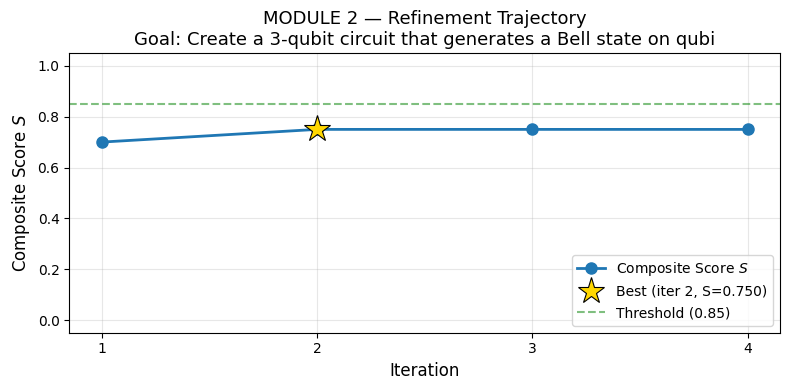

In [95]:
# ── Step 3: Visualise the score trajectory ──
plot_refinement_trajectory(simple_result)

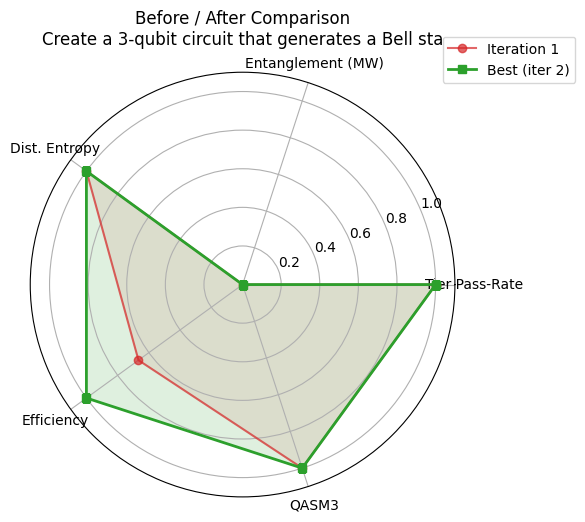

In [96]:
# ── Step 4: Before / After radar comparison ──
plot_before_after(simple_result)

In [97]:
# ── Step 5: Print the best circuit's full 7-tier report ──
print_report(simple_result["best"]["report"])

  EVALUATION REPORT  --  highest tier passed: 7 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 3
  num_gates  = 3

[Tier 2  Compilation]  pass=True
  logical depth      = 2
  logical gate counts = {'cx': 2, 'h': 1}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 2
  top-3 outcomes    = [('001', 512), ('000', 512)]

[Tier 4  QASM 3.0]  pass=True
  QASM length = 88 chars

[Tier 5  Transpilation]  pass=True
  ISA depth         = 3
  2-qubit gate count = 0
  ISA gate counts    = {'rz': 2, 'sx': 1}

[Tier 6  Hardware Exec]  pass=True
  distinct outcomes = 2

[Tier 7  Physics Metrics]  pass=True
  Meyer-Wallach          = 0.000000
  Entanglement entropy   = 0.000000  (mean over qubits)
  Distribution entropy   = 1.0000 bits
  KL div vs uniform      = 1.939246



In [98]:
# ── Step 6: Draw the best circuit ──
best_qc = build_qiskit_circuit(simple_result["best"]["circuit_spec"])
print(best_qc.draw())

     ┌───┐     
q_0: ┤ H ├─────
     └───┘     
q_1: ──■────■──
     ┌─┴─┐┌─┴─┐
q_2: ┤ X ├┤ X ├
     └───┘└───┘


## 16. Complex Refinement Stress Tests

Run the iterative refinement loop on **harder goals** where a single-shot
generation (MODULE 1) struggled.  The hypothesis is that critique-driven
iteration will push scores higher than the initial generation alone.

Each goal runs for up to **5 iterations** with `score_threshold=0.80`.

In [99]:
COMPLEX_REFINEMENT_GOALS = [
    # 1. W-state: genuine multipartite entanglement
    "Create a 3-qubit W-state circuit: the output should be an equal "
    "superposition of |001⟩, |010⟩, and |100⟩. Use Ry and CNOT gates. "
    "Measure all 3 qubits.",

    # 2. Variational ansatz with entangling layers
    "Design a 4-qubit variational ansatz with 2 layers. Each layer: "
    "Ry(θ) on every qubit, then a ring of CNOTs (0→1→2→3→0). "
    "Use θ = π/4 for all rotations. Measure all qubits.",

    # 3. Quantum error detection (bit-flip code)
    "Build a 3-qubit bit-flip error detection circuit: encode qubit 0 "
    "using two CNOT gates (0→1, 0→2), apply an X gate on qubit 0 to "
    "simulate an error, then decode with CNOT 0→1 and 0→2. "
    "Measure all 3 qubits.",

    # 4. Maximise Meyer-Wallach entanglement
    "Create a 4-qubit circuit that maximises the Meyer-Wallach "
    "entanglement measure. Use a combination of Hadamard gates and "
    "CNOT gates to entangle all qubits. The circuit depth should be "
    "between 4 and 8. Measure all qubits.",
]

print(f"Defined {len(COMPLEX_REFINEMENT_GOALS)} complex refinement goals")

Defined 4 complex refinement goals


In [100]:
# ── Run iterative refinement on all complex goals ──
complex_results = {}

for idx, goal in enumerate(COMPLEX_REFINEMENT_GOALS, 1):
    print(f"\n{'#'*60}")
    print(f"  COMPLEX GOAL {idx}/{len(COMPLEX_REFINEMENT_GOALS)}")
    print(f"  {goal[:80]}…" if len(goal) > 80 else f"  {goal}")
    print(f"{'#'*60}")

    result = refine_circuit(
        goal=goal,
        max_iterations=5,
        score_threshold=0.80,
        plateau_patience=2,
        verbose=True,
    )
    complex_results[f"goal_{idx}"] = result

print(f"\n\n{'='*60}")
print(f"  ALL COMPLEX REFINEMENTS COMPLETE")
print(f"{'='*60}")


############################################################
  COMPLEX GOAL 1/4
  Create a 3-qubit W-state circuit: the output should be an equal superposition of…
############################################################

  ITERATION 1/5
  [Generate] Creating initial circuit…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:22:10-INFO ======
SUCCESS


  0%|          | 0/2 [00:23<?, ?it/s]

  [Evaluate] Running 7-tier pipeline…
  Tier 1 [Schema]: PASS  (3q, 9 gates)
  Tier 2 [Compilation]: PASS  (depth=6)
  Tier 3 [Simulation]: PASS  (8 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (172 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=31, 2q gates=7)


  Tier 6 [Hardware Exec]: PASS  (8 outcomes)
  Tier 7 [Physics]: PASS  (MW=2.0000, H=2.994 bits)
  [Score]    S = 0.9830  (tiers passed: 7/7)
  [Critique] Generating improvement suggestions…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:23:04-INFO ======
SUCCESS


  0%|          | 0/2 [00:51<?, ?it/s]


  [Critique] 1. DIAGNOSIS: The current circuit does not produce the desired W-state output with equal superposition of |001⟩, |010⟩, and |100⟩. It appears to be a sequence of Ry and Rx rotations followed by CNOT operations, which may not have been designed to cre…
  [Best]     ★ New best score: 0.9830

  ✓ Score threshold reached (0.9830 >= 0.8)

  REFINEMENT COMPLETE
  Best score : 0.9830  (iteration 1)
  Trajectory : 0.983

────────────────────────────────────────────────────────────
  BEST CIRCUIT — 7-Tier Report (iteration 1)
────────────────────────────────────────────────────────────
  EVALUATION REPORT  --  highest tier passed: 7 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 3
  num_gates  = 9

[Tier 2  Compilation]  pass=True
  logical depth      = 6
  logical gate counts = {'cx': 4, 'ry': 2, 'rx': 2}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 8
  top-3 outcomes    = [('110', 143), ('000', 140), ('101', 137)]

[Tier 4  QASM 3.0]  pass=True
  QASM length = 172 char

  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:23:36-INFO ======
SUCCESS


  0%|          | 0/2 [00:32<?, ?it/s]

  [Evaluate] Running 7-tier pipeline…
  Tier 1 [Schema]: PASS  (4q, 15 gates)
  Tier 2 [Compilation]: PASS  (depth=13)
  Tier 3 [Simulation]: PASS  (16 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (275 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=50, 2q gates=14)


  Tier 6 [Hardware Exec]: PASS  (16 outcomes)
  Tier 7 [Physics]: PASS  (MW=1.6875, H=3.399 bits)
  [Score]    S = 0.9353  (tiers passed: 7/7)
  [Critique] Generating improvement suggestions…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:24:30-INFO ======
SUCCESS


  0%|          | 0/2 [00:51<?, ?it/s]


  [Critique] 1. DIAGNOSIS: The provided circuit does not fully adhere to the specified structure of 2 layers, each consisting of a Ry rotation followed by a ring of CNOTs. Additionally, the circuit includes unnecessary gates such as rz and cz, which do not align …
  [Best]     ★ New best score: 0.9353

  ✓ Score threshold reached (0.9353 >= 0.8)

  REFINEMENT COMPLETE
  Best score : 0.9353  (iteration 1)
  Trajectory : 0.935

────────────────────────────────────────────────────────────
  BEST CIRCUIT — 7-Tier Report (iteration 1)
────────────────────────────────────────────────────────────
  EVALUATION REPORT  --  highest tier passed: 7 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 4
  num_gates  = 15

[Tier 2  Compilation]  pass=True
  logical depth      = 13
  logical gate counts = {'ry': 6, 'cx': 6, 'rx': 1, 'rz': 1, 'cz': 1}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 16
  top-3 outcomes    = [('0000', 323), ('1000', 111), ('1101', 104)]

[Tier 4  QASM 3.0]  pass=True


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:24:52-INFO ======
SUCCESS


  0%|          | 0/2 [00:21<?, ?it/s]

  [Evaluate] Running 7-tier pipeline…
  Tier 1 [Schema]: PASS  (3q, 7 gates)
  Tier 2 [Compilation]: PASS  (depth=6)
  Tier 3 [Simulation]: PASS  (2 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (126 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=23, 2q gates=4)


  Tier 6 [Hardware Exec]: PASS  (8 outcomes)
  Tier 7 [Physics]: PASS  (MW=0.0000, H=1.000 bits)
  [Score]    S = 0.7000  (tiers passed: 7/7)
  [Critique] Generating improvement suggestions…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:25:47-INFO ======
SUCCESS


  0%|          | 0/2 [00:52<?, ?it/s]


  [Critique] 1. DIAGNOSIS: The provided circuit does not adhere to the goal of bit-flip error detection. It includes unnecessary Hadamard (H) gate on qubit 0, which is not required for encoding or decoding in a standard 3-qubit bit-flip error correction code (lik…
  [Best]     ★ New best score: 0.7000

  ITERATION 2/5
  [Refine]   Applying critique  (prev S = 0.7000)
  [History]  Feeding 1 past iteration(s) to LLM


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:26:33-INFO ======
SUCCESS


  0%|          | 0/2 [00:45<?, ?it/s]

  [Evaluate] Running 7-tier pipeline…
  Tier 1 [Schema]: PASS  (3q, 6 gates)
  Tier 2 [Compilation]: PASS  (depth=5)
  Tier 3 [Simulation]: PASS  (1 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (118 chars)


  Tier 5 [Transpilation]: PASS  (ISA depth=20, 2q gates=5)
  Tier 6 [Hardware Exec]: PASS  (7 outcomes)
  Tier 7 [Physics]: FAIL  (MW=0.0000, H=0.000 bits)
  [Score]    S = 0.4571  (tiers passed: 6/7)
  [Critique] Generating improvement suggestions…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:27:30-INFO ======
SUCCESS


  0%|          | 0/2 [00:50<?, ?it/s]


  [Critique] 1. DIAGNOSIS: The circuit provided does not correctly implement the bit-flip error detection process as described in the goal. Specifically, it fails to encode qubit 0 using two CNOT gates (0→1, 0→2), apply an X gate on qubit 0 to simulate an error, …

  ITERATION 3/5
  [Refine]   Applying critique  (prev S = 0.4571)
  [History]  Feeding 2 past iteration(s) to LLM


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:28:44-INFO ======
SUCCESS


  0%|          | 0/2 [01:13<?, ?it/s]

  [Evaluate] Running 7-tier pipeline…
  Tier 1 [Schema]: PASS  (3q, 6 gates)
  Tier 2 [Compilation]: PASS  (depth=5)
  Tier 3 [Simulation]: PASS  (1 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (118 chars)


  Tier 5 [Transpilation]: PASS  (ISA depth=25, 2q gates=7)
  Tier 6 [Hardware Exec]: PASS  (8 outcomes)
  Tier 7 [Physics]: FAIL  (MW=0.0000, H=0.000 bits)
  [Score]    S = 0.4571  (tiers passed: 6/7)
  [Critique] Generating improvement suggestions…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:29:28-INFO ======
SUCCESS


  0%|          | 0/2 [00:39<?, ?it/s]


  [Critique] 1. DIAGNOSIS: The provided circuit does not fully meet the goal of a bit-flip error detection circuit. While it performs the encoding (CNOT 0→1, 0→2) and applies an X gate on qubit 0 (simulating an error), it fails to decode the error using CNOT gate…
  [Plateau]  |ΔS| = 0.0000 (patience: 1/2)

  ITERATION 4/5
  [Refine]   Applying critique  (prev S = 0.4571)
  [History]  Feeding 3 past iteration(s) to LLM


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:31:04-INFO ======
SUCCESS


  0%|          | 0/2 [01:35<?, ?it/s]

  [Evaluate] Running 7-tier pipeline…
  Tier 1 [Schema]: PASS  (3q, 6 gates)
  Tier 2 [Compilation]: PASS  (depth=5)
  Tier 3 [Simulation]: PASS  (1 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (118 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=20, 2q gates=5)


  Tier 6 [Hardware Exec]: PASS  (8 outcomes)
  Tier 7 [Physics]: FAIL  (MW=0.0000, H=0.000 bits)
  [Score]    S = 0.4571  (tiers passed: 6/7)
  [Critique] Generating improvement suggestions…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:31:46-INFO ======
SUCCESS


  0%|          | 0/2 [00:40<?, ?it/s]


  [Critique] 1. DIAGNOSIS: The current circuit does not fully meet the goal of bit-flip error detection. It encodes qubit 0 using two CNOT gates (0→1, 0→2) correctly, but it fails to apply an X gate on qubit 0 to simulate an error and then decode with CNOT 0→1 an…
  [Plateau]  |ΔS| = 0.0000 (patience: 2/2)

  ✓ Score plateau detected after 2 stall(s)

  REFINEMENT COMPLETE
  Best score : 0.7000  (iteration 1)
  Trajectory : 0.700 → 0.457 → 0.457 → 0.457

────────────────────────────────────────────────────────────
  BEST CIRCUIT — 7-Tier Report (iteration 1)
────────────────────────────────────────────────────────────
  EVALUATION REPORT  --  highest tier passed: 7 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 3
  num_gates  = 7

[Tier 2  Compilation]  pass=True
  logical depth      = 6
  logical gate counts = {'cx': 4, 'h': 1, 'x': 1}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 2
  top-3 outcomes    = [('110', 520), ('111', 504)]

[Tier 4  QASM 3.0]  pass=True
  QASM leng

  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:32:08-INFO ======
SUCCESS


  0%|          | 0/2 [00:21<?, ?it/s]

  [Evaluate] Running 7-tier pipeline…
  Tier 1 [Schema]: PASS  (4q, 10 gates)
  Tier 2 [Compilation]: PASS  (depth=5)
  Tier 3 [Simulation]: PASS  (4 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (158 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=33, 2q gates=7)


  Tier 6 [Hardware Exec]: PASS  (16 outcomes)
  Tier 7 [Physics]: PASS  (MW=2.0000, H=1.999 bits)
  [Score]    S = 0.9999  (tiers passed: 7/7)
  [Critique] Generating improvement suggestions…


  0%|          | 0/2 [00:00<?, ?it/s]

=== 03:32:55-INFO ======
SUCCESS


  0%|          | 0/2 [00:44<?, ?it/s]

  [Critique] 1. DIAGNOSIS: The current circuit successfully entangles all qubits using Hadamard and CNOT gates, but the Meyer-Wallach entanglement measure is not maximized due to insufficient depth. The circuit depth of 5 is within the acceptable range, but it co…
  [Best]     ★ New best score: 0.9999

  ✓ Score threshold reached (0.9999 >= 0.8)

  REFINEMENT COMPLETE
  Best score : 0.9999  (iteration 1)
  Trajectory : 1.000

────────────────────────────────────────────────────────────
  BEST CIRCUIT — 7-Tier Report (iteration 1)
────────────────────────────────────────────────────────────
  EVALUATION REPORT  --  highest tier passed: 7 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 4
  num_gates  = 10

[Tier 2  Compilation]  pass=True
  logical depth      = 5
  logical gate counts = {'h': 6, 'cx': 4}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 4
  top-3 outcomes    = [('0111', 265), ('0000', 261), ('1011', 251)]

[Tier 4  QASM 3.0]  pass=True
  QASM length = 158 chars

[Ti

In [101]:
# ── Comparative summary table ──
print(f"\n{'='*80}")
print(f"  MODULE 2 — COMPLEX REFINEMENT RESULTS SUMMARY")
print(f"{'='*80}")
print(f"{'Goal':<6} {'Iters':>5} {'Init S':>7} {'Best S':>7} {'ΔS':>7} {'Best Iter':>9}")
print(f"{'─'*80}")

for key, res in complex_results.items():
    traj = res["trajectory"]
    init_s = traj[0]
    best_s = res["best"]["score"]
    delta = best_s - init_s
    print(f"{key:<6} {res['iterations_run']:>5} {init_s:>7.3f} {best_s:>7.3f} "
          f"{delta:>+7.3f} {res['best']['iteration']:>9}")

print(f"{'─'*80}")
avg_improvement = np.mean([
    r["best"]["score"] - r["trajectory"][0]
    for r in complex_results.values()
])
print(f"  Average improvement (ΔS): {avg_improvement:+.4f}")
print(f"{'='*80}")


  MODULE 2 — COMPLEX REFINEMENT RESULTS SUMMARY
Goal   Iters  Init S  Best S      ΔS Best Iter
────────────────────────────────────────────────────────────────────────────────
goal_1     1   0.983   0.983  +0.000         1
goal_2     1   0.935   0.935  +0.000         1
goal_3     4   0.700   0.700  +0.000         1
goal_4     1   1.000   1.000  +0.000         1
────────────────────────────────────────────────────────────────────────────────
  Average improvement (ΔS): +0.0000


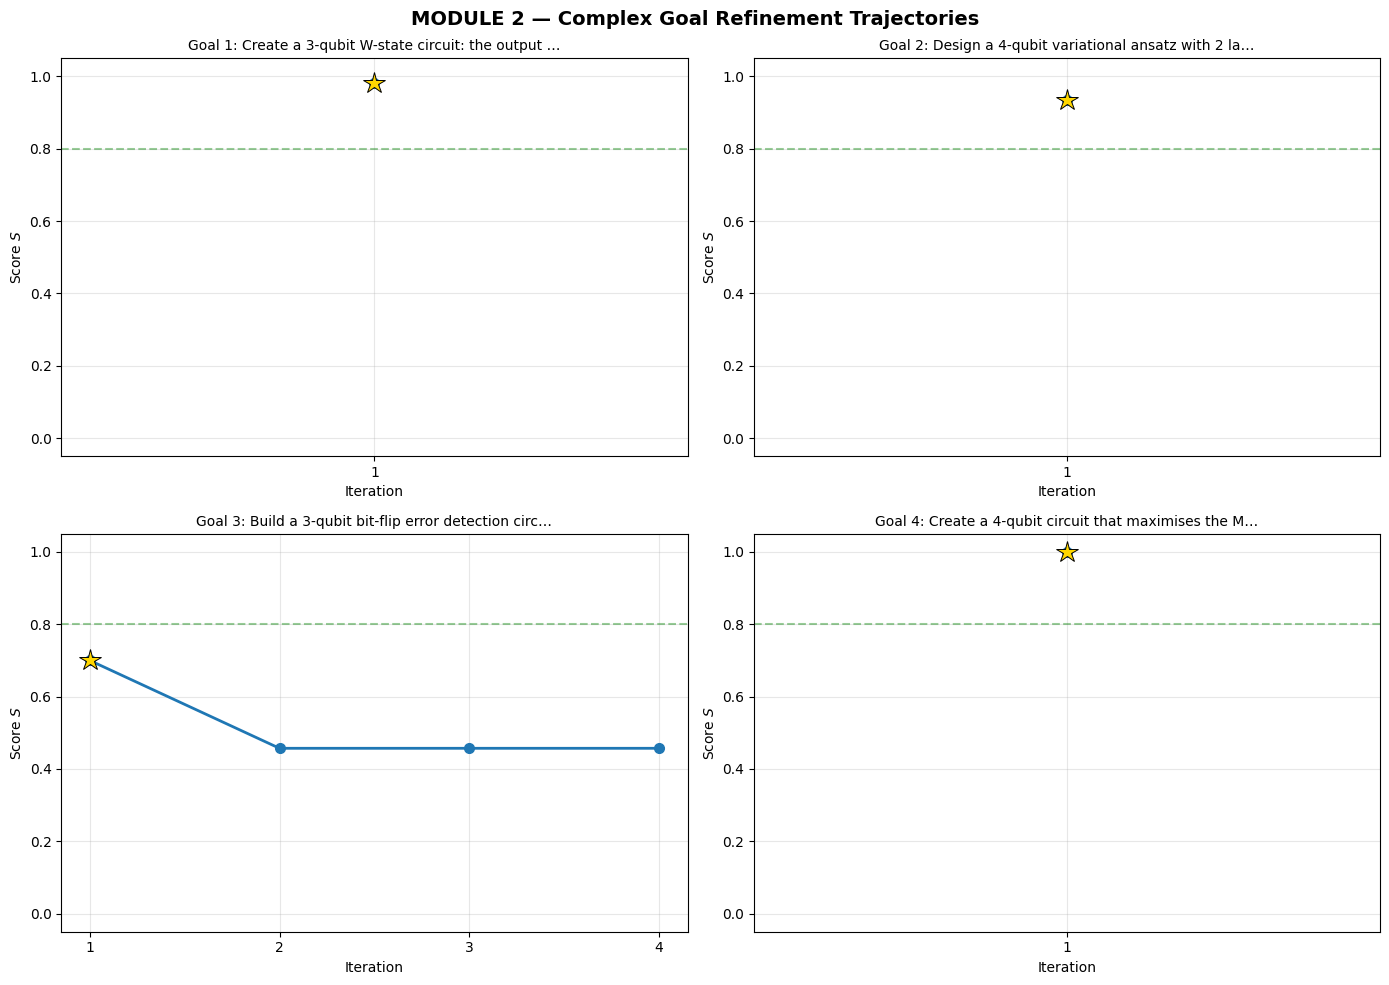

In [102]:
# ── Visualise all trajectories on one plot ──
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (key, res) in enumerate(complex_results.items()):
    ax = axes[idx]
    traj = res["trajectory"]
    iters = list(range(1, len(traj) + 1))
    best_i = res["best"]["iteration"]
    best_s = res["best"]["score"]

    ax.plot(iters, traj, "o-", linewidth=2, markersize=7, color="#1f77b4")
    ax.plot(best_i, best_s, "*", markersize=16, color="gold",
            markeredgecolor="black", markeredgewidth=0.7)
    ax.axhline(y=0.80, color="green", linestyle="--", alpha=0.4)
    ax.set_title(f"Goal {idx+1}: {res['goal'][:45]}…", fontsize=10)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Score $S$")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(iters)
    ax.grid(True, alpha=0.3)

plt.suptitle("MODULE 2 — Complex Goal Refinement Trajectories",
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## 17. Summary — MODULE 2

### What was implemented

| Component | Section | Purpose |
|-----------|---------|---------|
| `compute_composite_score()` | §10 | Aggregate 7-tier results into a single scalar $S \in [0,1]$ |
| `critique_circuit()` | §11 | LLM-as-critic: structured DIAGNOSIS / GATE_CHANGES / STRUCTURE / PRIORITY feedback |
| `build_refinement_prompt()` | §12 | Inject previous circuit, score, $\Delta S$, and critique into the next generation prompt |
| `refine_circuit()` | §13 | **Core loop**: Generate → Evaluate → Critique → Re-generate with convergence detection |
| Visualisation utilities | §14 | Score trajectory plot, radar before/after comparison, text summary |

### Architecture

```
 ┌──────────────────────────────────────────────────────────┐
 │                   MODULE 2 — Refine                      │
 │                                                          │
 │  Iteration 0:  generate_circuit(goal)                    │
 │       ↓                                                  │
 │  evaluate_circuit() → compute_composite_score() → S₀     │
 │       ↓                                                  │
 │  critique_circuit() → structured feedback                │
 │       ↓                                                  │
 │  Iteration 1:  build_refinement_prompt(ΔS, critique)     │
 │       ↓          ↓                                       │
 │  LLM generates improved circuit                          │
 │       ↓                                                  │
 │  evaluate → score S₁ → critique → …                     │
 │       ↓                                                  │
 │  Repeat until converged or max_iterations                │
 └──────────────────────────────────────────────────────────┘
```

### Key design choices

1. **Self-Refine paradigm** (Madaan et al., NeurIPS 2023) — the same LLM generates
   *and* critiques, avoiding a separate reward model.
2. **Score-difference feedback** ($\Delta S$) — the prompt explicitly tells the model
   whether its last edit helped or hurt, enabling directed search.
3. **Plateau detection** — avoids wasting compute on stalled refinements
   ($|\Delta S| < 0.005$ for `plateau_patience` consecutive iterations).
4. **Fallback re-generation** — if the LLM fails to produce valid JSON during
   refinement, the loop falls back to a fresh generation rather than crashing.

### References

- Madaan, A. et al. (2023). *Self-Refine: Iterative Refinement with Self-Feedback.*
  NeurIPS 2023.
- Putta, P. et al. (2025). *Agent Q: Advanced Reasoning and Learning for
  Autonomous AI Agents.* arXiv:2504.11109.
- Macarone-Palmieri, A. & Lo Franco, R. (2025). *Discovering quantum circuits
  through reinforcement learning.* arXiv:2602.03466.

---